In [1]:
from logistic_sgd import *
import scipy.misc as smp
import matplotlib.pyplot as plt
import importlib

/home/max/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/max/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Choose learning parameters.
1. learning_rate : magnitude of a step taken with respect to gradient descent
2. n_epochs : number of gradient descent steps taken
3. batch_size : 

In [2]:
learning_rate=0.01
n_epochs=1000
batch_size=600

# Load mnist dataset

In [3]:
dataset='mnist.pkl.gz'

datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

... loading data


## How we can visualize our data

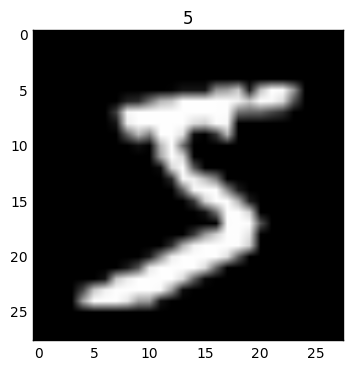

In [4]:
example = train_set_x.get_value()[0]
img = example.reshape((28,28))

plt.imshow(img, cmap='Greys_r')
plt.title(str(5))
plt.show()

# Build logistic regressor model out of tensors

Scalar representing mini-batch index

In [5]:
index = T.lscalar()

## Creating image variable and labels

1. x : a matrix of images where each row is a 2d image that has been flattened into an array

2. y: a vector of labels each element or column is a number from 0-9 representing the true number in the image.

In [6]:
x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

## Create a classifier and a cost tensor

In [7]:
# construct the logistic regression class
# Each MNIST image has size 28*28
classifier = LogisticRegression(input=x, n_in=28 * 28, n_out=10)

# the cost we minimize during training is the negative log likelihood of
# the model in symbolic format
cost = classifier.negative_log_likelihood(y)

## Create validation and test functions

In [8]:
# compiling a Theano function that computes the mistakes that are made by
# the model on a minibatch
test_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

## Define gradient descent

In [9]:
# compute the gradient of cost with respect to theta = (W,b)
g_W = T.grad(cost=cost, wrt=classifier.W)
g_b = T.grad(cost=cost, wrt=classifier.b)

# start-snippet-3
# specify how to update the parameters of the model as a list of
# (variable, update expression) pairs.
updates = [(classifier.W, classifier.W - learning_rate * g_W),
           (classifier.b, classifier.b - learning_rate * g_b)]

# compiling a Theano function `train_model` that returns the cost, but in
# the same time updates the parameter of the model based on the rules
# defined in `updates`
train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

# Actually train model

## Specify early stopping parameters

In [10]:
# early-stopping parameters
patience = 1000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                              # found
improvement_threshold = 0.995  # a relative improvement of this much is
                              # considered significant
validation_frequency = min(n_train_batches, patience // 2)
                              # go through this many
                              # minibatche before checking the network
                              # on the validation set; in this case we
                              # check every epoch

## Training
Train until we have done more than the maximum number of epochs or we have not seen significant decrease
in error an our patience has run out

Optimization complete with best validation score of 8.541667 %,with test performance 8.333333 %
The code run for 166 epochs, with 13.061792 epochs/sec


The code ran for 12.7s


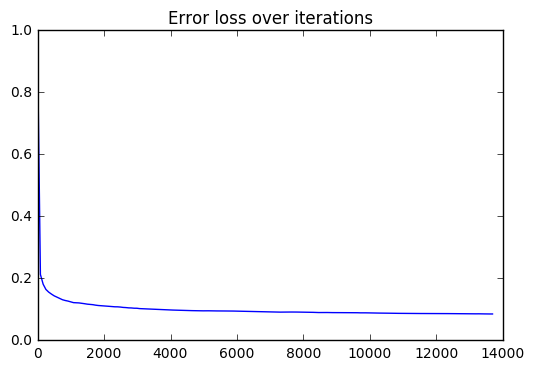

In [11]:
iterations = []
losses = []

best_validation_loss = numpy.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0
validation_losses = [validate_model(i)
                                 for i in range(n_valid_batches)]
this_validation_loss = numpy.mean(validation_losses)
iterations.append(0)
losses.append(this_validation_loss)

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)
        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = [validate_model(i)
                                 for i in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            iterations.append(iter)
            losses.append(this_validation_loss)
            
            #print(this_validation_loss.shape)
            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:
                #improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss *  \
                   improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss
                # test it on the test set

                test_losses = [test_model(i)
                               for i in range(n_test_batches)]
                test_score = numpy.mean(test_losses)

                
        if patience <= iter:
            done_looping = True
            break

end_time = timeit.default_timer()
print(
    (
        'Optimization complete with best validation score of %f %%,'
        'with test performance %f %%'
    )
    % (best_validation_loss * 100., test_score * 100.)
)
print('The code run for %d epochs, with %f epochs/sec' % (
    epoch, 1. * epoch / (end_time - start_time)))
print(('The code ran for %.1fs' % ((end_time - start_time))), file=sys.stderr)



plt.plot(iterations, losses)
plt.title("Error loss over iterations")
plt.show()

# Test out our classifier

... loading data
(10, 784)


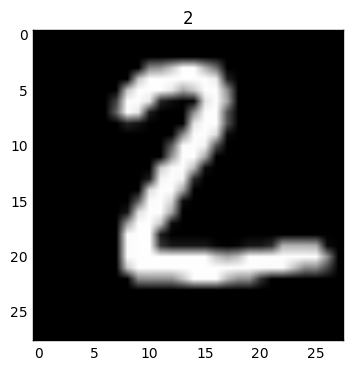

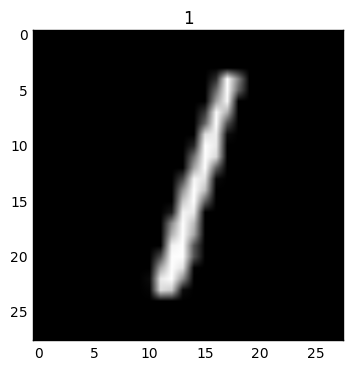

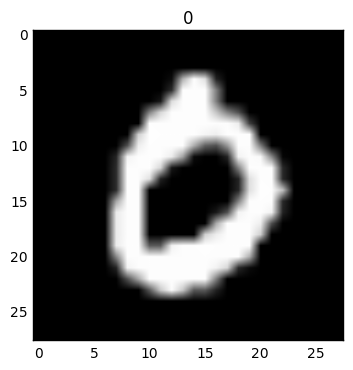

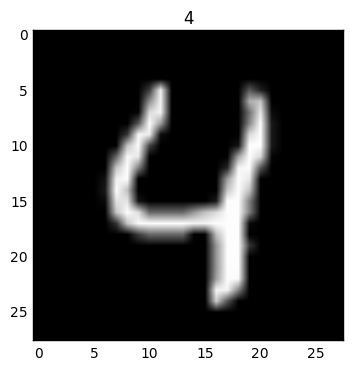

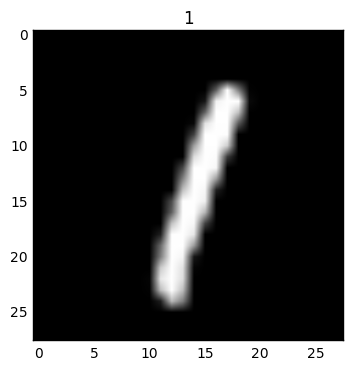

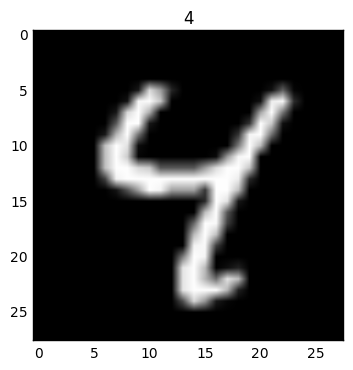

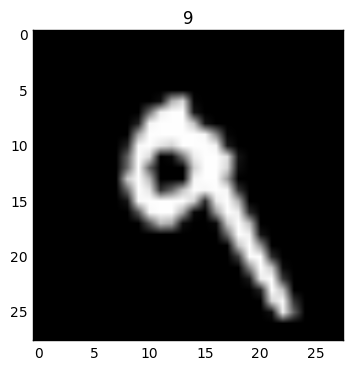

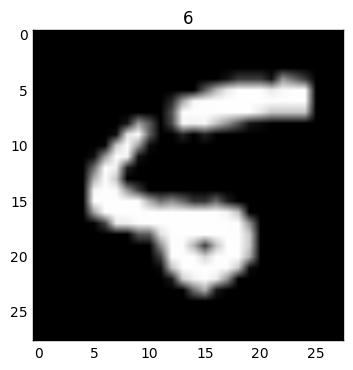

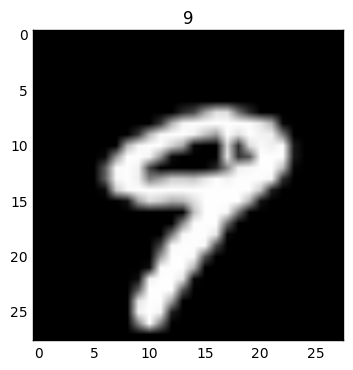

In [12]:
n = 10
predict_model = theano.function(inputs=[classifier.input],outputs=classifier.y_pred)
dataset='mnist.pkl.gz'
datasets = load_data(dataset)
test_set_x, test_set_y = datasets[2]
test_set_x = test_set_x.get_value()
n = min(n, len(test_set_x))
print(test_set_x[:n].shape)
predicted_values = predict_model(test_set_x[:n])
show_predictions(test_set_x[:n],predicted_values)

# Special Bonus Round !
Can you finish this code so that it learns the goal number?

In [ ]:
goal_num = numpy.array([2],dtype=numpy.int32)

goal_image = numpy.empty((1,28*28))##numpy.random.rand(1,28*28)
goal_image.fill(0.5)

In [ ]:
g_x = T.grad(cost=cost, wrt=x)



gradient = theano.function(inputs=[x,y], outputs=g_x)

dot.0
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.26158384e-05  -4.46645619e-05  -1.53543730e-04  -6.39765541e-06
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    2.05908431e-06   6.90312220e-06   8.85775591e-05   2.90712850e-04
    1.95625598e-04   6.88589835e-04   9.49496750e-04   1.30553956e-03
    1.24241503e-03   1.09001985e-03   5.10050586e-04  -1.29200754e-03
   -4.61316350e-03  -3.84911235e-05   7.68576035e-04   7.54399059e-04
    6.27975531e-04   4.39784162e-04   9.00837585e-05   2.22770986e-05
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000

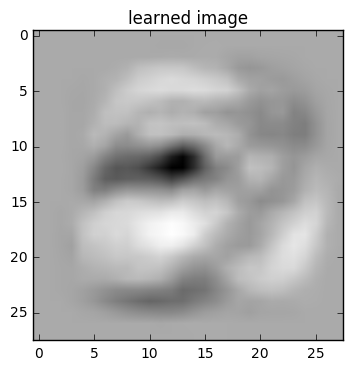

[2]


In [27]:
print(gradient(goal_image, goal_num))


for i in range(20000):
    goal_image -= 0.01 * gradient(goal_image, goal_num)

img = goal_image[0].reshape((28,28))

plt.imshow(img, cmap='Greys_r')
plt.title('learned image')
plt.show()

print(predict_model(goal_image))